In [1]:
import json
import os
import numpy as np
from analysis_util import *
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
filehandler = open('parsed_results/real_results.obj', 'rb') 
real_results = pd.DataFrame.from_dict(pickle.load(filehandler))

In [3]:
aggregate_real_results_df = aggregate_real_results(real_results)
display(aggregate_real_results_df)

,surrogate,acquisition,seed,data,dist_nearest_train,inst_regret_test,inst_regret_pool,tot_regret_test,tot_regret_pool,std_change,calibration_mse,sharpness,x_opt_dist_test,x_opt_dist_pool,elpd
0,BNN,UCB,25,fashionmnist,1.310057,0.009012,0.003380,9.077342,8.508445,1.0,0.088364,0.988819,3.109387,2.056537,-8.358932e+01
1,RF,TS,67,fashionmnist,1.096183,0.008770,0.000000,2.668899,1.783089,1.0,0.006928,-0.515190,1.159039,0.000000,-2.814406e+10
2,DE,RS,93,fashionmnist,1.188979,0.066877,0.054267,7.171189,5.897592,1.0,0.010897,-0.094937,2.934265,2.463365,-3.505381e-01
3,GP,TS,40,fashionmnist,0.933712,0.012433,0.007686,5.323852,4.844387,1.0,0.027271,-0.935378,0.782267,2.628219,-1.102442e+00
4,RF,TS,23,fashionmnist,1.052692,0.009154,0.000000,1.250953,0.326413,1.0,0.012390,-0.411589,2.582823,0.000000,-6.081807e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,BNN,TS,85,svm_wine,0.331033,0.000000,0.000000,0.000000,0.000000,1.0,0.097939,1.578599,1.285102,1.346839,-2.353185e+02
9596,GP,UCB,68,svm_wine,0.370231,0.000000,0.000000,0.000000,0.000000,1.0,0.021145,-0.679767,1.099158,2.091784,-1.961209e+00
9597,GP,TS,77,svm_wine,0.377340,0.000000,0.000000,0.000000,0.000000,1.0,0.021799,-0.604018,1.057315,1.576296,-1.989144e+00
9598,GP,RS,52,svm_wine,0.182310,0.000000,0.000000,0.000000,0.000000,1.0,0.010603,0.740182,1.427660,1.324073,-1.395769e+01


In [4]:
real_results_highlighted, latex_results = BO_performance_table1_real_results(aggregate_real_results_df)
#display(aggregate_real_results_df)
display(real_results_highlighted)
display(latex_results)
with open("./tables/real_performance_vanilla.txt", "w") as file:
    latex_str = latex_results.to_latex(index=False)
    latex_str = latex_str.replace('\\textbackslash pm', '$\pm$')
    print(latex_str)
    file.write(latex_str)
###END OF REAL RESULTS WITHOUT RECALIBRATION

,surrogate,acquisition,inst_regret_pool,inst_regret_pool_ste,tot_regret_pool,tot_regret_pool_ste,calibration_mse,calibration_mse_ste,sharpness,sharpness_ste
15,BNN,EI,0.033170,0.001780,4.843010,0.223950,0.105180,0.000660,0.792760,0.013640
14,DE,EI,0.001140,0.000120,0.903140,0.043610,0.036320,0.000960,-0.292650,0.009640
12,GP,EI,0.003090,0.000220,1.537540,0.056480,0.015310,0.000420,-0.543280,0.015460
13,RF,EI,0.004270,0.000260,1.092540,0.045920,0.014590,0.000360,0.871820,0.076080
7,BNN,RS,0.014990,0.000670,2.594770,0.094250,0.101540,0.000460,1.349950,0.010210
6,DE,RS,0.016100,0.000720,2.782230,0.103270,0.009290,0.000130,-0.257380,0.013380
4,GP,RS,0.015130,0.000630,2.702120,0.099480,0.005500,0.000110,-0.776220,0.013850
5,RF,RS,0.015190,0.000670,2.697740,0.101840,0.007230,0.000170,1.030180,0.101650
3,BNN,TS,0.017610,0.000850,2.990030,0.123090,0.102470,0.000540,1.064350,0.009090
2,DE,TS,0.001630,0.000150,1.032120,0.048920,0.036380,0.000930,-0.252220,0.009970


,Surrogate,Acquisition,Inst. Regret,Total Regret,Calibration Error,Sharpness
15,BNN,EI,0.03317 \pm 0.00178,4.84301 \pm 0.22395,0.10518 \pm 0.00066,0.79276 \pm 0.01364
14,DE,EI,0.00114 \pm 0.00012,0.90314 \pm 0.04361,0.03632 \pm 0.00096,-0.29265 \pm 0.00964
12,GP,EI,0.00309 \pm 0.00022,1.53754 \pm 0.05648,0.01531 \pm 0.00042,-0.54328 \pm 0.01546
13,RF,EI,0.00427 \pm 0.00026,1.09254 \pm 0.04592,0.01459 \pm 0.00036,0.87182 \pm 0.07608
7,BNN,RS,0.01499 \pm 0.00067,2.59477 \pm 0.09425,0.10154 \pm 0.00046,1.34995 \pm 0.01021
6,DE,RS,0.0161 \pm 0.00072,2.78223 \pm 0.10327,0.00929 \pm 0.00013,-0.25738 \pm 0.01338
4,GP,RS,0.01513 \pm 0.00063,2.70212 \pm 0.09948,0.0055 \pm 0.00011,-0.77622 \pm 0.01385
5,RF,RS,0.01519 \pm 0.00067,2.69774 \pm 0.10184,0.00723 \pm 0.00017,1.03018 \pm 0.10165
3,BNN,TS,0.01761 \pm 0.00085,2.99003 \pm 0.12309,0.10247 \pm 0.00054,1.06435 \pm 0.00909
2,DE,TS,0.00163 \pm 0.00015,1.03212 \pm 0.04892,0.03638 \pm 0.00093,-0.25222 \pm 0.00997


\begin{tabular}{llllll}
\toprule
Surrogate & Acquisition &        Inst. Regret &        Total Regret &   Calibration Error &            Sharpness \\
\midrule
      BNN &          EI & 0.03317 $\pm$ 0.00178 & 4.84301 $\pm$ 0.22395 & 0.10518 $\pm$ 0.00066 &  0.79276 $\pm$ 0.01364 \\
       DE &          EI & 0.00114 $\pm$ 0.00012 & 0.90314 $\pm$ 0.04361 & 0.03632 $\pm$ 0.00096 & -0.29265 $\pm$ 0.00964 \\
       GP &          EI & 0.00309 $\pm$ 0.00022 & 1.53754 $\pm$ 0.05648 & 0.01531 $\pm$ 0.00042 & -0.54328 $\pm$ 0.01546 \\
       RF &          EI & 0.00427 $\pm$ 0.00026 & 1.09254 $\pm$ 0.04592 & 0.01459 $\pm$ 0.00036 &  0.87182 $\pm$ 0.07608 \\
      BNN &          RS & 0.01499 $\pm$ 0.00067 & 2.59477 $\pm$ 0.09425 & 0.10154 $\pm$ 0.00046 &  1.34995 $\pm$ 0.01021 \\
       DE &          RS &  0.0161 $\pm$ 0.00072 & 2.78223 $\pm$ 0.10327 & 0.00929 $\pm$ 0.00013 & -0.25738 $\pm$ 0.01338 \\
       GP &          RS & 0.01513 $\pm$ 0.00063 & 2.70212 $\pm$ 0.09948 &  0.0055 $\pm$ 0.00011 & 

/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_42571/786282483.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = latex_results.to_latex(index=False)


In [5]:
filehandler = open('parsed_results/real_results_recal.obj', 'rb') 
real_results = pd.DataFrame.from_dict(pickle.load(filehandler))

In [6]:
aggregate_real_results_df = aggregate_real_results(real_results)
display(aggregate_real_results_df)

,surrogate,acquisition,seed,data,dist_nearest_train,inst_regret_test,inst_regret_pool,tot_regret_test,tot_regret_pool,std_change,calibration_mse,sharpness,x_opt_dist_test,x_opt_dist_pool,elpd
0,GP,TS,95,fashionmnist,1.159449,0.034314,0.017718,5.496141,3.819892,1.0,0.006209,-0.753961,3.612029,2.403939,-1.273836
1,BNN,UCB,17,fashionmnist,1.154577,0.051747,0.053570,5.226403,5.410594,1.0,0.072204,0.061497,1.782798,3.355696,-25.005504
2,DE,RS,71,fashionmnist,1.258037,0.014566,0.010533,8.950080,8.542668,1.0,0.006462,-0.625449,1.206509,1.255487,-0.492357
3,GP,EI,14,fashionmnist,0.904022,0.000226,0.000000,5.224769,5.241719,1.0,0.012181,-0.224039,0.698753,0.000000,-2.929074
4,GP,EI,23,fashionmnist,0.832996,0.009154,0.000000,1.371516,0.446976,1.0,0.031711,-0.764924,2.582823,0.000000,-1.580949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9594,DE,TS,41,svm_wine,0.526839,0.000000,0.000000,0.000000,0.000000,1.0,0.016586,-0.538779,2.340714,1.430192,-2.221699
9595,GP,RS,80,svm_wine,0.161732,0.000000,0.000000,0.000000,0.000000,1.0,0.007162,-0.716922,0.395320,1.513633,-1.370794
9596,BNN,TS,60,svm_wine,0.313483,0.000000,0.000000,0.000000,0.000000,1.0,0.094930,1.335917,1.209033,0.481576,-85.570162
9597,DE,UCB,4,svm_wine,0.427564,0.000000,0.000000,0.000000,0.000000,1.0,0.021010,-0.029282,2.471372,0.925521,-12.883618


In [7]:
real_results_highlighted, latex_results = BO_performance_table1_real_results(aggregate_real_results_df)
#display(aggregate_real_results_df)
display(real_results_highlighted)
display(latex_results)
with open("./tables/real_performance_recal.txt", "w") as file:
    latex_str = latex_results.to_latex(index=False)
    latex_str = latex_str.replace('\\textbackslash pm', '$\pm$')
    print(latex_str)
    file.write(latex_str)
###RECALIBRATE REAL DATA DONE

,surrogate,acquisition,inst_regret_pool,inst_regret_pool_ste,tot_regret_pool,tot_regret_pool_ste,calibration_mse,calibration_mse_ste,sharpness,sharpness_ste
15,BNN,EI,0.062310,0.003110,6.786390,0.334280,0.092050,0.000560,0.501020,0.015570
14,DE,EI,0.001980,0.000180,1.159410,0.056360,0.043420,0.000850,-0.304430,0.007350
12,GP,EI,0.006000,0.000340,1.894350,0.072660,0.016410,0.000400,-0.651830,0.009950
13,RF,EI,0.003170,0.000220,1.106120,0.050150,0.011840,0.000220,-0.570950,0.008420
7,BNN,RS,0.015600,0.000700,2.680880,0.097910,0.104110,0.000480,2.101280,0.018630
6,DE,RS,0.016100,0.000720,2.782230,0.103270,0.006260,0.000100,-0.599940,0.007650
4,GP,RS,0.015130,0.000630,2.702120,0.099480,0.005820,0.000100,-0.842600,0.007850
5,RF,RS,0.015190,0.000670,2.697740,0.101840,0.007260,0.000130,-0.434000,0.007880
3,BNN,TS,0.017850,0.000830,2.947880,0.117070,0.100270,0.000550,1.385280,0.013850
2,DE,TS,0.001750,0.000150,1.105280,0.050930,0.038140,0.000770,-0.327190,0.006950


,Surrogate,Acquisition,Inst. Regret,Total Regret,Calibration Error,Sharpness
15,BNN,EI,0.06231 \pm 0.00311,6.78639 \pm 0.33428,0.09205 \pm 0.00056,0.50102 \pm 0.01557
14,DE,EI,0.00198 \pm 0.00018,1.15941 \pm 0.05636,0.04342 \pm 0.00085,-0.30443 \pm 0.00735
12,GP,EI,0.006 \pm 0.00034,1.89435 \pm 0.07266,0.01641 \pm 0.0004,-0.65183 \pm 0.00995
13,RF,EI,0.00317 \pm 0.00022,1.10612 \pm 0.05015,0.01184 \pm 0.00022,-0.57095 \pm 0.00842
7,BNN,RS,0.0156 \pm 0.0007,2.68088 \pm 0.09791,0.10411 \pm 0.00048,2.10128 \pm 0.01863
6,DE,RS,0.0161 \pm 0.00072,2.78223 \pm 0.10327,0.00626 \pm 0.0001,-0.59994 \pm 0.00765
4,GP,RS,0.01513 \pm 0.00063,2.70212 \pm 0.09948,0.00582 \pm 0.0001,-0.8426 \pm 0.00785
5,RF,RS,0.01519 \pm 0.00067,2.69774 \pm 0.10184,0.00726 \pm 0.00013,-0.434 \pm 0.00788
3,BNN,TS,0.01785 \pm 0.00083,2.94788 \pm 0.11707,0.10027 \pm 0.00055,1.38528 \pm 0.01385
2,DE,TS,0.00175 \pm 0.00015,1.10528 \pm 0.05093,0.03814 \pm 0.00077,-0.32719 \pm 0.00695


\begin{tabular}{llllll}
\toprule
Surrogate & Acquisition &        Inst. Regret &        Total Regret &   Calibration Error &            Sharpness \\
\midrule
      BNN &          EI & 0.06231 $\pm$ 0.00311 & 6.78639 $\pm$ 0.33428 & 0.09205 $\pm$ 0.00056 &  0.50102 $\pm$ 0.01557 \\
       DE &          EI & 0.00198 $\pm$ 0.00018 & 1.15941 $\pm$ 0.05636 & 0.04342 $\pm$ 0.00085 & -0.30443 $\pm$ 0.00735 \\
       GP &          EI &   0.006 $\pm$ 0.00034 & 1.89435 $\pm$ 0.07266 &  0.01641 $\pm$ 0.0004 & -0.65183 $\pm$ 0.00995 \\
       RF &          EI & 0.00317 $\pm$ 0.00022 & 1.10612 $\pm$ 0.05015 & 0.01184 $\pm$ 0.00022 & -0.57095 $\pm$ 0.00842 \\
      BNN &          RS &   0.0156 $\pm$ 0.0007 & 2.68088 $\pm$ 0.09791 & 0.10411 $\pm$ 0.00048 &  2.10128 $\pm$ 0.01863 \\
       DE &          RS &  0.0161 $\pm$ 0.00072 & 2.78223 $\pm$ 0.10327 &  0.00626 $\pm$ 0.0001 & -0.59994 $\pm$ 0.00765 \\
       GP &          RS & 0.01513 $\pm$ 0.00063 & 2.70212 $\pm$ 0.09948 &  0.00582 $\pm$ 0.0001 & 

/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_42571/1517475486.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = latex_results.to_latex(index=False)


In [12]:
#Synthetic data now!
filehandler = open('parsed_results/synth_results.obj', 'rb') 
synth_results = pd.DataFrame.from_dict(pickle.load(filehandler))

In [13]:
display(synth_results)

,surrogate,acquisition,seed,problem_name,problem_idx,dim,data,dist_nearest_train,inst_regret_test,inst_regret_pool,tot_regret_test,tot_regret_pool,calibration_mse,sharpness,x_opt_dist_test,x_opt_dist_pool,path
0,GP,TS,15,Brown,12,6,benchmark,"[[2.6665446745047734], [2.2917412587147536], [...","[0.1460387705447252, 0.1460387705447252, 0.146...","[0.1990469563205834, 0.1990469563205834, 0.199...","[0.1460387705447252, 0.2920775410894504, 0.438...","[0.1990469563205834, 0.3980939126411668, 0.597...","[0.023565175829346897, 0.024490248739470085, 0...","[-0.8652701929122512, -0.8308945815580002, -1....","[1.803757816210712, 1.803757816210712, 1.80375...","[3.9353488931312945, 3.9353488931312945, 3.935...",./results_synth_data/experiment-GP--(3881)--11...
1,BNN,UCB,6,Sphere,6,4,benchmark,"[[1.8047030543706886], [1.2178445802711586], [...","[0.2829642692048209, 0.2829642692048209, 0.282...","[0.2841852079881668, 0.2841852079881668, 0.284...","[0.2829642692048209, 0.5659285384096417, 0.848...","[0.2841852079881668, 0.5683704159763336, 0.852...","[0.07280794296288391, 0.06881476779038272, 0.0...","[1.0082275021209963, 0.9283395392199473, 1.191...","[1.7036500646560193, 1.7036500646560193, 1.703...","[1.5458934429607893, 1.5458934429607893, 1.545...",./results_synth_data/experiment-BNN--(2204)--1...
2,GP,UCB,12,Schwefel20,3,6,benchmark,"[[0.6957571107345966], [0.9719793307394036], [...","[0.30596785582536734, 0.06662972284878554, 0.0...","[0.3725975786741529, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.30596785582536734, 0.3725975786741529, 0.43...","[0.3725975786741529, 0.3725975786741529, 0.372...","[0.04214538154005063, 0.050958729409974014, 0....","[-1.2892857370021602, -1.3262772709371233, -1....","[0.9935003204169389, 0.6869571927016913, 0.686...","[0.6957571107345966, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./results_synth_data/experiment-GP--(3686)--11...
3,GP,TS,14,Sargan,1,9,benchmark,"[[2.774082344173155], [3.3966416042157386], [2...","[1.6201093514565306, 1.6201093514565306, 1.620...","[1.3798816676796004, 1.3798816676796004, 1.379...","[1.6201093514565306, 3.240218702913061, 4.8603...","[1.3798816676796004, 2.759763335359201, 4.1396...","[0.001130106462277429, 0.0018392474606920104, ...","[-1.2123482552384075, -1.1739092787394574, -1....","[3.356072513368975, 3.356072513368975, 3.35607...","[4.2201340314797156, 4.2201340314797156, 4.220...",./results_synth_data/experiment-GP--(3829)--11...
4,GP,TS,19,Step,6,10,benchmark,"[[2.557184811671302], [3.507929936139601], [2....","[0.7315305207098617, 0.7315305207098617, 0.731...","[0.5909501548207459, 0.5909501548207459, 0.590...","[0.7315305207098617, 1.4630610414197234, 2.194...","[0.5909501548207459, 1.1819003096414917, 1.772...","[0.02237790422518248, 0.022985885510378865, 0....","[-1.5162665346684736, -1.4678338490872613, -1....","[1.8943426336203313, 1.8943426336203313, 1.894...","[1.924772371583328, 1.924772371583328, 1.92477...",./results_synth_data/experiment-GP--(5055)--11...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,GP,TS,6,Schwefel01,11,10,benchmark,"[[2.8840724170204357], [1.5138734124933406], [...","[0.27634697768087957, 0.27634697768087957, 0.2...","[0.31223205576461277, 0.31223205576461277, 0.3...","[0.27634697768087957, 0.5526939553617591, 0.82...","[0.31223205576461277, 0.6244641115292255, 0.93...","[0.00967669172810914, 0.008999931654178159, 0....","[-1.627409806751151, -1.5802944063418916, -1.5...","[2.127597557022193, 2.127597557022193, 2.12759...","[2.466194091904589, 2.466194091904589, 2.46619...",./results_synth_data/experiment-GP--(1480)--10...
40956,DE,RS,1,Schwefel22,11,2,benchmark,"[[1.1624108629254821], [0.8819382434010882], [...","[0.6241776195529568, 0.46910771317903466, 0.46...","[0.5241401342298496, 0.36907022785592747, 0.36...","[0.6241776195529568, 1.0932853327319916, 1.562...","[0.5241401342298496, 0.8932103620857771, 1.262...","[0.012038845519177426, 0.027487773185487535, 0...","[0.24557906875863555, 0.44846102317385805, 0.5...",

In [15]:
aggregated_results = aggregate_synthetic_results(synth_results)
styled_table, latex_table = BO_performance_table1_synth_results(aggregated_results)
display(styled_table)
display(latex_table)
with open("./tables/synth_performance_vanilla.txt", "w") as file:
    latex_str = latex_table.to_latex(index=False)
    latex_str = latex_str.replace('\\textbackslash pm', '$\pm$')
    print(latex_str)
    file.write(latex_str)

,surrogate,acquisition,inst_regret_pool,inst_regret_pool_ste,tot_regret_pool,tot_regret_pool_ste,calibration_mse,calibration_mse_ste,sharpness,sharpness_ste
0,GP,TS,0.041100,0.002700,28.728900,1.044000,0.010000,0.000200,-0.436000,0.011400
1,RF,TS,0.279000,0.012800,51.165700,1.782900,0.012900,0.000200,-0.451100,0.014700
2,DE,TS,0.042300,0.001700,22.116100,0.507800,0.026900,0.000500,-0.333500,0.008900
3,BNN,TS,0.627900,0.021300,76.085800,2.330000,0.091200,0.000700,0.997400,0.007000
4,GP,RS,0.495600,0.017700,67.116700,2.155100,0.005000,0.000100,-0.183400,0.012500
5,RF,RS,0.511100,0.018400,67.920000,2.205500,0.006200,0.000100,-0.477600,0.015600
6,DE,RS,0.507900,0.018600,67.345300,2.193800,0.011300,0.000100,0.030100,0.006600
7,BNN,RS,0.518700,0.018700,67.990400,2.198700,0.087700,0.000500,1.253400,0.008200
8,GP,UCB,0.027500,0.001000,12.828600,0.328400,0.017200,0.000300,-0.322300,0.012000
9,RF,UCB,0.081000,0.003100,31.172900,0.944700,0.025300,0.000400,-0.404000,0.015800


,Surrogate,Acquisition,Inst. Regret,Total Regret,Calibration Error,Sharpness
0,GP,TS,0.0411 \pm 0.0027,28.7289 \pm 1.044,0.01 \pm 0.0002,-0.436 \pm 0.0114
1,RF,TS,0.279 \pm 0.0128,51.1657 \pm 1.7829,0.0129 \pm 0.0002,-0.4511 \pm 0.0147
2,DE,TS,0.0423 \pm 0.0017,22.1161 \pm 0.5078,0.0269 \pm 0.0005,-0.3335 \pm 0.0089
3,BNN,TS,0.6279 \pm 0.0213,76.0858 \pm 2.33,0.0912 \pm 0.0007,0.9974 \pm 0.007
4,GP,RS,0.4956 \pm 0.0177,67.1167 \pm 2.1551,0.005 \pm 0.0001,-0.1834 \pm 0.0125
5,RF,RS,0.5111 \pm 0.0184,67.92 \pm 2.2055,0.0062 \pm 0.0001,-0.4776 \pm 0.0156
6,DE,RS,0.5079 \pm 0.0186,67.3453 \pm 2.1938,0.0113 \pm 0.0001,0.0301 \pm 0.0066
7,BNN,RS,0.5187 \pm 0.0187,67.9904 \pm 2.1987,0.0877 \pm 0.0005,1.2534 \pm 0.0082
8,GP,UCB,0.0275 \pm 0.001,12.8286 \pm 0.3284,0.0172 \pm 0.0003,-0.3223 \pm 0.012
9,RF,UCB,0.081 \pm 0.0031,31.1729 \pm 0.9447,0.0253 \pm 0.0004,-0.404 \pm 0.0158


\begin{tabular}{llllll}
\toprule
Surrogate & Acquisition &      Inst. Regret &       Total Regret & Calibration Error &          Sharpness \\
\midrule
       GP &          TS & 0.0411 $\pm$ 0.0027 &  28.7289 $\pm$ 1.044 &   0.01 $\pm$ 0.0002 &  -0.436 $\pm$ 0.0114 \\
       RF &          TS &  0.279 $\pm$ 0.0128 & 51.1657 $\pm$ 1.7829 & 0.0129 $\pm$ 0.0002 & -0.4511 $\pm$ 0.0147 \\
       DE &          TS & 0.0423 $\pm$ 0.0017 & 22.1161 $\pm$ 0.5078 & 0.0269 $\pm$ 0.0005 & -0.3335 $\pm$ 0.0089 \\
      BNN &          TS & 0.6279 $\pm$ 0.0213 &   76.0858 $\pm$ 2.33 & 0.0912 $\pm$ 0.0007 &   0.9974 $\pm$ 0.007 \\
       GP &          RS & 0.4956 $\pm$ 0.0177 & 67.1167 $\pm$ 2.1551 &  0.005 $\pm$ 0.0001 & -0.1834 $\pm$ 0.0125 \\
       RF &          RS & 0.5111 $\pm$ 0.0184 &   67.92 $\pm$ 2.2055 & 0.0062 $\pm$ 0.0001 & -0.4776 $\pm$ 0.0156 \\
       DE &          RS & 0.5079 $\pm$ 0.0186 & 67.3453 $\pm$ 2.1938 & 0.0113 $\pm$ 0.0001 &  0.0301 $\pm$ 0.0066 \\
      BNN &          RS & 0.51

/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_42571/1309902596.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = latex_table.to_latex(index=False)


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def regret_vs_calib_plot(df, save_fig=False, aggregate="None"):
    markers = ["o", "v", "s", "x", "d"]
    colors = plt.cm.plasma(np.linspace(0, 1, len(markers)))
    if aggregate == "None":
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        for i_s, surrogate in enumerate(surrogates):
            if surrogate != "RS":
                selection = df[(df['surrogate']==surrogate) & (df['acquisition'] != "RS")]
                xs = selection['inst_regret_pool']
                ys = selection['calibration_mse']
                plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
            else:
                selection = df[(df['acquisition'] == "RS")]
                xs = selection['inst_regret_pool']
                ys = selection['calibration_mse']
                plt.scatter(xs, ys, marker=markers[i_s], color=colors[i_s], label=surrogate)
    elif aggregate=="seeds":
        datasets = ['fashionmnist', 'fashionmnist_cnn', 'mnist', 'mnist_cnn', 'news', 'svm_wine']
        acquisitions = ['EI', 'UCB', 'TS']
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        aggregate_dict = {'surrogate': [], 'inst_regret_pool':[], 'calibration_mse':[]}
        for surrogate in surrogates:
            for acq in acquisitions:
                for dataset in datasets:
                    if surrogate != "RS":
                        selection = df[(df['surrogate'] == surrogate) & (df['acquisition']==acq) & (df['data'] == dataset)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
                    else:
                        selection = df[(df['acquisition']==acq) & (df['data'] == dataset)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
        aggregate_df = pd.DataFrame.from_dict(aggregate_dict)
        for i_s, surrogate in enumerate(surrogates):
            selection = aggregate_df[(aggregate_df['surrogate']==surrogate)]
            xs = selection['inst_regret_pool']
            ys = selection['calibration_mse']
            plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
    elif aggregate=="data":
        seeds = set(df['seed'])
        acquisitions = ['EI', 'UCB', 'TS']
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        aggregate_dict = {'surrogate': [], 'inst_regret_pool':[], 'calibration_mse':[]}
        for surrogate in surrogates:
            for acq in acquisitions:
                for seed in seeds:
                    if surrogate != "RS":
                        selection = df[(df['surrogate'] == surrogate) & (df['acquisition']==acq) & (df['seed'] == seed)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
                    else:
                        selection = df[(df['acquisition']==acq) & (df['seed'] == seed)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
        aggregate_df = pd.DataFrame.from_dict(aggregate_dict)
        for i_s, surrogate in enumerate(surrogates):
            selection = aggregate_df[(aggregate_df['surrogate']==surrogate)]
            xs = selection['inst_regret_pool']
            ys = selection['calibration_mse']
            plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('regret')
    plt.ylabel('calib')
    plt.grid()
    plt.legend()
    plt.show()
    
def regret_vs_calib_plot_synth(df, save_fig=False, aggregate="None"):
    markers = ["o", "v", "s", "x", "d"]
    colors = plt.cm.plasma(np.linspace(0, 1, len(markers)))
    if aggregate == "None":
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        for i_s, surrogate in enumerate(surrogates):
            if surrogate != "RS":
                selection = df[(df['surrogate']==surrogate) & (df['acquisition'] != "RS")]
                xs = selection['inst_regret_pool']
                ys = selection['calibration_mse']
                plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
            else:
                selection = df[(df['acquisition'] == "RS")]
                xs = selection['inst_regret_pool']
                ys = selection['calibration_mse']
                plt.scatter(xs, ys, marker=markers[i_s], color=colors[i_s], label=surrogate)
    elif aggregate=="seeds":
        problem_names = set(df['problem_name'])
        acquisitions = ['EI', 'UCB', 'TS']
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        aggregate_dict = {'surrogate': [], 'inst_regret_pool':[], 'calibration_mse':[]}
        for surrogate in surrogates:
            for acq in acquisitions:
                for problem_name in problem_names:
                    if surrogate != "RS":
                        selection = df[(df['surrogate'] == surrogate) & (df['acquisition']==acq) & (df['problem_name'] == problem_name)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
                    else:
                        selection = df[(df['acquisition']==acq) & (df['data'] == dataset)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
        aggregate_df = pd.DataFrame.from_dict(aggregate_dict)
        for i_s, surrogate in enumerate(surrogates):
            selection = aggregate_df[(aggregate_df['surrogate']==surrogate)]
            xs = selection['inst_regret_pool']
            ys = selection['calibration_mse']
            plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
    elif aggregate=="data":
        seeds = set(df['seed'])
        acquisitions = ['EI', 'UCB', 'TS']
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        aggregate_dict = {'surrogate': [], 'inst_regret_pool':[], 'calibration_mse':[]}
        for surrogate in surrogates:
            for acq in acquisitions:
                for seed in seeds:
                    if surrogate != "RS":
                        selection = df[(df['surrogate'] == surrogate) & (df['acquisition']==acq) & (df['seed'] == seed)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
                    else:
                        selection = df[(df['acquisition']==acq) & (df['seed'] == seed)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
        aggregate_df = pd.DataFrame.from_dict(aggregate_dict)
        for i_s, surrogate in enumerate(surrogates):
            selection = aggregate_df[(aggregate_df['surrogate']==surrogate)]
            xs = selection['inst_regret_pool']
            ys = selection['calibration_mse']
            plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('regret')
    plt.ylabel('calib')
    plt.grid()
    plt.legend()
    plt.show()

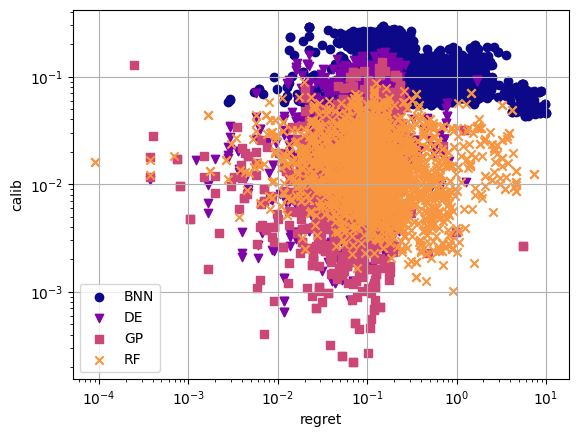

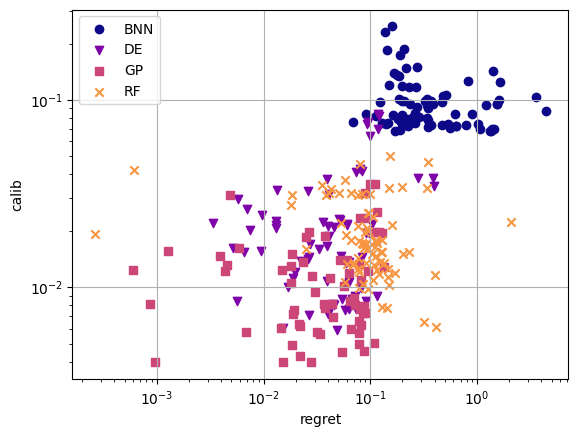

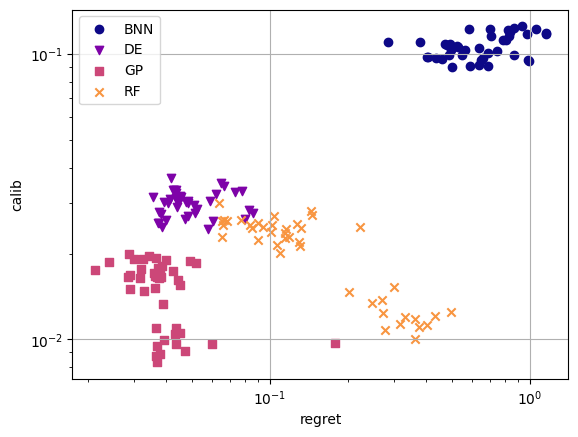

In [66]:
filehandler = open('parsed_results/real_results.obj', 'rb') 
synth_results = pd.DataFrame.from_dict(pickle.load(filehandler))
aggregate_synth_results_df = aggregate_synthetic_results(real_results)
#regret_vs_calib_plot(aggregate_real_results_df, aggregate="data")
#regret_vs_calib_plot(aggregate_real_results_df, aggregate="seeds")
#regret_vs_calib_plot(aggregate_real_results_df)
filehandler = open('parsed_results/synth_results.obj', 'rb') 
synth_results = pd.DataFrame.from_dict(pickle.load(filehandler))
aggregate_synth_results_df = aggregate_synthetic_results(synth_results)
regret_vs_calib_plot_synth(aggregate_synth_results_df)#, aggregate="seeds")
regret_vs_calib_plot_synth(aggregate_synth_results_df, aggregate="seeds")
regret_vs_calib_plot_synth(aggregate_synth_results_df, aggregate="data")

In [ ]:
#DONE: Syntestiske eksperiment check - dimension indexering? 
#ANSWER: Indexeres efter dimension også problem. Hvis aggregate, over både problem idx og dimension.
#DONE: Ændre np.sqrt(n) i standard error of the mean.

#DONE: Horizontal line at the end of each acquisition.
#DONE: Insert midrule automatically.
#ANSWER: Simpler to just do this stuff manually...
#DONE: Scatter plot (regret vs. calibration) hvor det er muligt at aggregate fleksibelt.

#DONE: Sæt pertubation eksperimenter over.

#DONE: Regressions analyse. Inklusiv p værdier. 1. Fuldstændig vanilla regression for alle punkter på slope.


In [47]:
import json
problems = json.load(open("./datasets/benchmarks/unibo-problems.json"))
problems_names = []
for key in problems.keys():
    problems_names.extend(problems[key])
print(set(problems_names))

{'Leon', 'Problem15', 'Problem04', 'MegaDomain04', 'Giunta', 'SumPowers', 'Brent', 'Plateau', 'Brown', 'Ackley', 'Step', 'Cigar', 'Adjiman', 'Sargan', 'Csendes', 'HimmelBlau', 'Quadratic', 'Schwefel06', 'Ursem04', 'McCourt27', 'MegaDomain02', 'Sphere', 'Schwefel20', 'BartelsConn', 'MegaDomain03', 'Problem18', 'Problem13', 'Schwefel22', 'MegaDomain01', 'Schwefel36', 'Schwefel01', 'Exponential', 'McCourt28'}


In [17]:
set(synth_results[synth_results['problem_name'] == "SumPowers"]['dim'])

{1, 2, 4, 5, 6, 7, 8, 10}